# Linear Model Selection & Regularization

## Goals of the lab:
* Learn to use the _regsubsets_ function.
* Learn to use the _glmnet_ function.
* Learn to use the _pcr_ function and the _plsr_ function.
* **Understand that hyperparameter selection should also be validated.**

This lab draws from the practice sets at the end of Chapter 6 in James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). "An introduction to statistical learning: with applications in r." 

---
# Best subset selection

First we start with a tour of using the built-in functions for best subset selection. For this we will load the [Hitters (baseball) dataset](https://vincentarelbundock.github.io/Rdatasets/doc/ISLR/Hitters.html) included in ISLR.

In [1]:
# -----------------------------
# 6.5.1 Best subset selection
# -----------------------------

# Load the Baseball dataset
library(ISLR)
names(Hitters)
dim(Hitters)

# Uncomment the line below to see the help function for the data set.
#help(Hitters)

[1] "AtBat"     "Hits"      "HmRun"     "Runs"      "RBI"       "Walks"    
 [7] "Years"     "CAtBat"    "CHits"     "CHmRun"    "CRuns"     "CRBI"     
[13] "CWalks"    "League"    "Division"  "PutOuts"   "Assists"   "Errors"   
[19] "Salary"    "NewLeague"

[1] 322  20

One thing to notice is that this data set has a lot of missing values that are indicated as `na` in r. R includes a library of functions that are useful for dealing with missing data. 

In [2]:
n_missing_values <- sum(is.na(Hitters)) 
print(n_missing_values)
# R lets you filter out the empty values using na.omit

# Using na.omit to make a new data set that only includes
# those observations where all variables are observed
Hitters=na.omit(Hitters)

dim(Hitters) # Notice that the dimensions reduced by 59 rows
sum(is.na(Hitters)) # And there are no longer any "na" values

[1] 59


[1] 263  20

[1] 0

Now that we've cleaned the data set, let's work with best subset selection.

In [3]:
# We will perform subset selection using regsubsets(), that is 
# part of the leaps package

# Uncomment the line below if you haven't installed the leaps package yet
# install.packages("leaps")
library(leaps)

For this practice we will be using the [regsubsets function](https://www.rdocumentation.org/packages/leaps/versions/2.1-1/topics/regsubsets). The `regsubsets` function identifies the best model as a function of the number of predictors it has. Here, 'best' is quantified as adjusted R^2, Bayesian Information Criterion scores (BIC) or Mallow's Cp. 

Let's see which aspects of a hitter's performance best accounts for annual salary. In this model we'll use all 19 variables (other than Salary, which is our outcome).

In [4]:
# regsubsets uses the same model configuration as lm()
# so, configure the model in regsubsets as regsubsets(model, data)
regfit.full = regsubsets(Salary~., Hitters) #use every variable EXCEPT salary as a predictor
summary(regfit.full) # Asterisks indicate that a field is included in the model

Subset selection object
Call: regsubsets.formula(Salary ~ ., Hitters)
19 Variables  (and intercept)
           Forced in Forced out
AtBat          FALSE      FALSE
Hits           FALSE      FALSE
HmRun          FALSE      FALSE
Runs           FALSE      FALSE
RBI            FALSE      FALSE
Walks          FALSE      FALSE
Years          FALSE      FALSE
CAtBat         FALSE      FALSE
CHits          FALSE      FALSE
CHmRun         FALSE      FALSE
CRuns          FALSE      FALSE
CRBI           FALSE      FALSE
CWalks         FALSE      FALSE
LeagueN        FALSE      FALSE
DivisionW      FALSE      FALSE
PutOuts        FALSE      FALSE
Assists        FALSE      FALSE
Errors         FALSE      FALSE
NewLeagueN     FALSE      FALSE
1 subsets of each size up to 8
Selection Algorithm: exhaustive
         AtBat Hits HmRun Runs RBI Walks Years CAtBat CHits CHmRun CRuns CRBI
1  ( 1 ) " "   " "  " "   " "  " " " "   " "   " "    " "   " "    " "   "*" 
2  ( 1 ) " "   "*"  " "   " "  " " " "   

The asterisks indicate when a field is included in the model. The way to interpret this summary is that each row indicates the variables to include with models of increasing complexity. The first row is a one-dimensional model (i.e., 1 variable, only includes CRBI). The second row is a two-dimensional model and so on.

You may have also noticed the `Forced in` and `Forced out` columns. This reflects whether you have manually included or excluded variables in the subset selection. For example, if I excluded `AtBat`, then the `Forced out` colum for that variable would read `True`.

By default `regsubsets()` only searches for the best model with up to 8 predictors (*p=8*). Let's expand that default maximum to include all 19 variables. For this we'll use the _nvmax_ option.

In [5]:
regfit.full = regsubsets(Salary~., Hitters, nvmax=19) #select up to 19 variables
reg.summary = summary(regfit.full)
reg.summary

Subset selection object
Call: regsubsets.formula(Salary ~ ., Hitters, nvmax = 19)
19 Variables  (and intercept)
           Forced in Forced out
AtBat          FALSE      FALSE
Hits           FALSE      FALSE
HmRun          FALSE      FALSE
Runs           FALSE      FALSE
RBI            FALSE      FALSE
Walks          FALSE      FALSE
Years          FALSE      FALSE
CAtBat         FALSE      FALSE
CHits          FALSE      FALSE
CHmRun         FALSE      FALSE
CRuns          FALSE      FALSE
CRBI           FALSE      FALSE
CWalks         FALSE      FALSE
LeagueN        FALSE      FALSE
DivisionW      FALSE      FALSE
PutOuts        FALSE      FALSE
Assists        FALSE      FALSE
Errors         FALSE      FALSE
NewLeagueN     FALSE      FALSE
1 subsets of each size up to 19
Selection Algorithm: exhaustive
          AtBat Hits HmRun Runs RBI Walks Years CAtBat CHits CHmRun CRuns CRBI
1  ( 1 )  " "   " "  " "   " "  " " " "   " "   " "    " "   " "    " "   "*" 
2  ( 1 )  " "   "*"  " "  

We now have a full evaluation of the best subset selection. So to find which of these subsets is the best model we'll have to evaluate the bias-adjusted model fit measures (adjusting for complexity) that are output.

In [6]:
# See what is included in the summary object
attributes(reg.summary)

$names
[1] "which"  "rsq"    "rss"    "adjr2"  "cp"     "bic"    "outmat" "obj"   

$class
[1] "summary.regsubsets"

Instead of looking at the asterisks above, you can also directly query which variables were included for each model using the `which` attribute.

In [7]:
# You can directly query which terms are included at each level of complexity
reg.summary$which

,(Intercept),AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,LeagueN,DivisionW,PutOuts,Assists,Errors,NewLeagueN
1,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
2,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
3,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE
4,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE
5,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE
6,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE
7,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE
8,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE
9,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE,FALSE,FALSE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE
10,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE,FALSE,FALSE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,FALSE,FALSE


In [8]:
rowSums(reg.summary$which) #get the sum of variables included for each row (these include the intercept)

1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 
 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20

Now let's look at the adjusted model fit for each of these models.

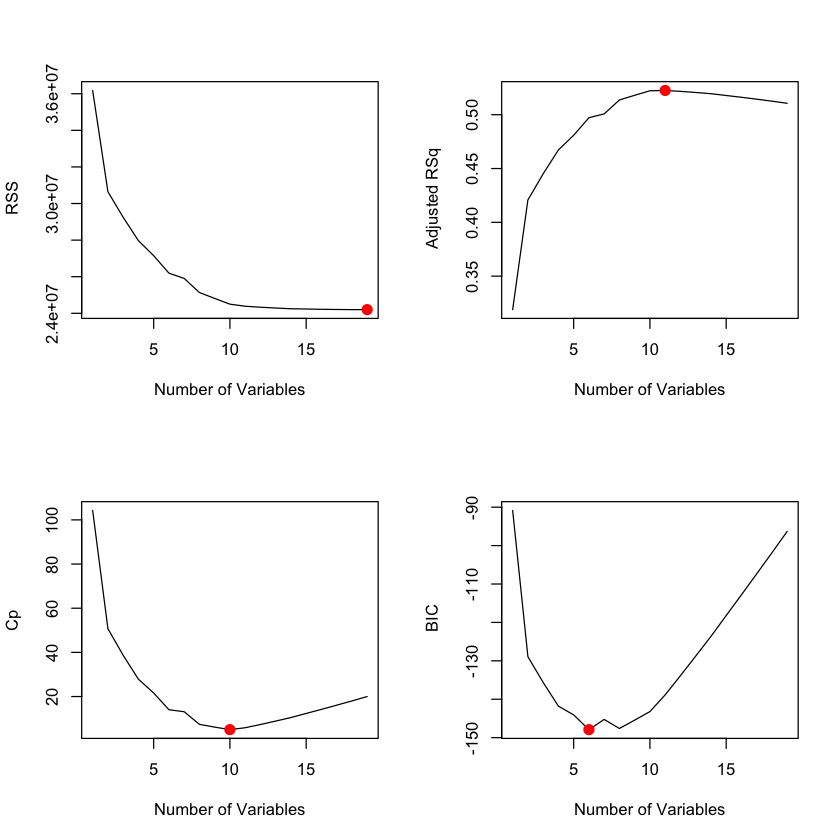

In [9]:
par(mfrow =c(2,2))

#rss
rss_min_idx = which.min(reg.summary$rss)
plot(reg.summary$rss ,xlab=" Number of Variables ",ylab=" RSS",
type="l")
points(rss_min_idx, reg.summary$rss[rss_min_idx], col='red', cex =2, pch = 20)

#adjr2
adjr2_max_idx = which.max(reg.summary$adjr2)
plot(reg.summary$adjr2 ,xlab =" Number of Variables ",ylab=" Adjusted RSq",type="l")
points(adjr2_max_idx, reg.summary$adjr2[adjr2_max_idx], col ="red",cex =2, pch =20)

#mallow's cp 
cp_min_idx = which.min(reg.summary$cp)
plot(reg.summary$cp ,xlab =" Number of Variables ",ylab="Cp",type="l")
points (cp_min_idx, reg.summary$cp[cp_min_idx], col ="red",cex =2, pch =20)

#bic
bic_min_idx = which.min(reg.summary$bic)
plot(reg.summary$bic ,xlab=" Number of Variables ",ylab=" BIC",type="l")
points (bic_min_idx,reg.summary$bic[bic_min_idx], col =" red",cex =2, pch =20)

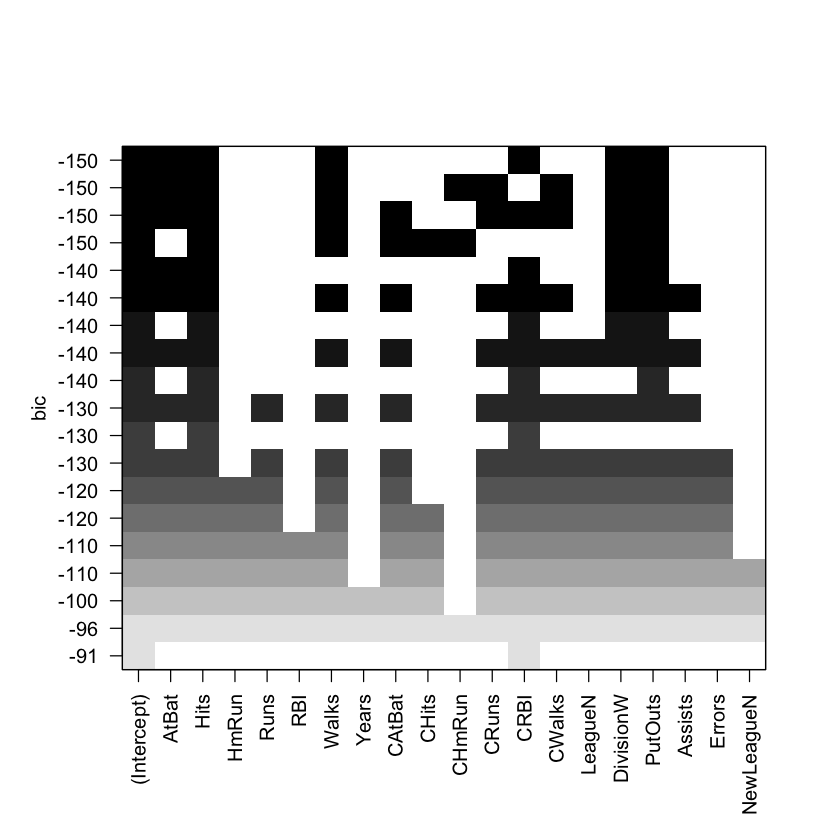

In [10]:
# You can also use the built-in plots from regsubset()

plot(regfit.full, scale="bic") #BIC
# plot(regfit.full, scale="adjr2") #adjusted R^2
# plot(regfit.full, scale="Cp") #Mallow's Cp

Here, the top row of each plot contains a black square for each variable selected,
according to the model associated with that BIC. For example,
we see that many models have a BIC of ~ −150. However, the model
with the lowest BIC contains only six variables: AtBat,
Hits, Walks, CRBI, DivisionW, and PutOuts. 

In [11]:
# identify which model has the best bias-adjusted fit
which.min(reg.summary$bic) 
which.max(reg.summary$adjr2)
which.min(reg.summary$cp)

[1] 6

[1] 11

[1] 10

Right now, there's a clear discrepancy in fit among the bias-adjusted model evaluations. 

We could also try a crossvalidation approach to select the best model. While there's no `predict` method for `regsubsets`, there is a method for prediction outlined in the book, pg. 248-250.

---
# Ridge Regression
<br>
Now we'll try to ask the same question using ridge regression. For this we can use the [_glmnet_ package](https://cran.r-project.org/web/packages/glmnet/glmnet.pdf). 

In [12]:
# -----------------------------
# 6.6.1 Ridge regression
# -----------------------------

# Uncomment the following line if glmnet isn't installed yet
# install.packages("glmnet")
library(glmnet)

Warning message:
“package ‘glmnet’ was built under R version 3.4.4”Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16



Remember that, for ridge regression, you need to find the best tuning parameter ($\lambda$) to use. This tuning parameter determines the sparsity of the model, or the impact of each predictor, using the L2 norm. This contrasts with LASSO, which conducts *feature selection* using the L1 norm. 

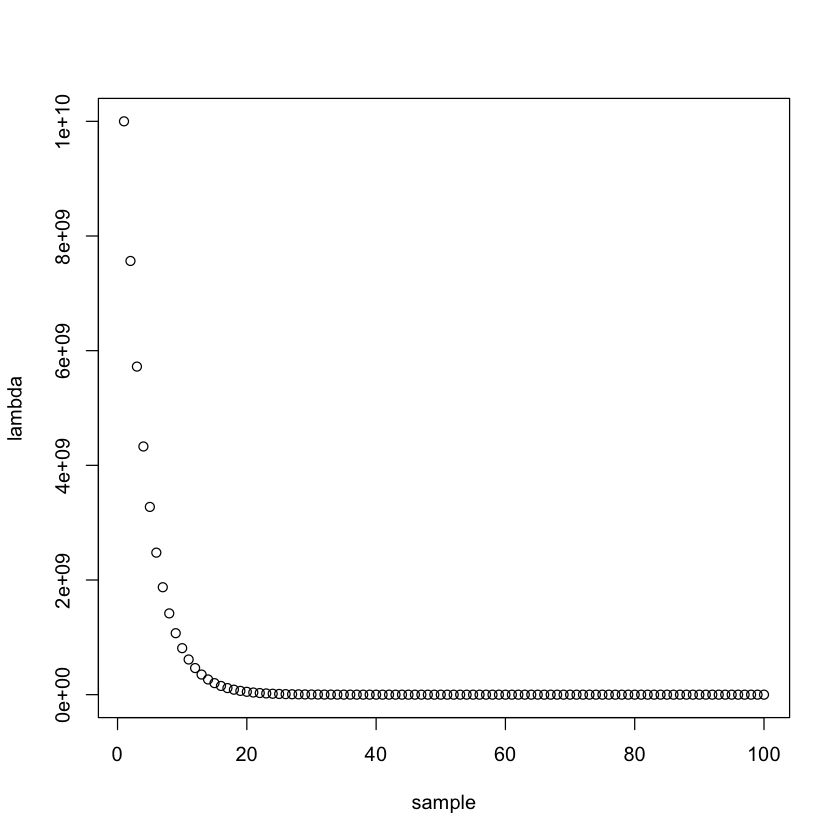

In [13]:
# Use a non-linear search on lambda
lambda_search_space = 10^seq(10, -2, length=100) #create a search space from (10^10):(10^-2), 100 samples long
plot(lambda_search_space, xlab="sample", ylab="lambda")

#this will span a range of models, from the null model containing only the intercept (lambda = 10^10, extremely sparse)
#to the least squares fit (lambda = 0, lenient)

In [14]:
# The glmnet package requires that you use matrices instead of dataframes, 
# and that x and y are specified separately 

# So, let's select x and y 
# Define x without the first column
x = model.matrix(Salary~., Hitters)[,-1] #without first intercept column
#the model.matrix function also automatically transforms qualitative variables
#into dummy variables
y = Hitters$Salary #selecting y from the dataframe

Now, technically you are using an _elastic net_ algorithm when using the _glmnet_ function. So we have to set $\alpha$ to zero in order to run pure ridge regression. Remember, if $\alpha$ is 0, then a ridge regression model is fit, and if $\alpha$ is 1, then a LASSO model is fit.

In [15]:
ridge.mod = glmnet(x, y, alpha=0, lambda=lambda_search_space)

Remember that ridge regression returns all _p_ variables for each value of $\lambda$. Thus we get a matrix of regression coefficients instead of a vector.

In [16]:
dim(coef(ridge.mod)) #this gives 20 rows (one for each predictor, plus a new intercept)
#and 100 columns, one for each value of lambda in the search space

[1]  20 100

Let's look at all 20 coefficients (including the intercept) when $\lambda = 11497.57$ (i.e., the 50th entry in the $\lambda$ vector)

[1] 11497.57

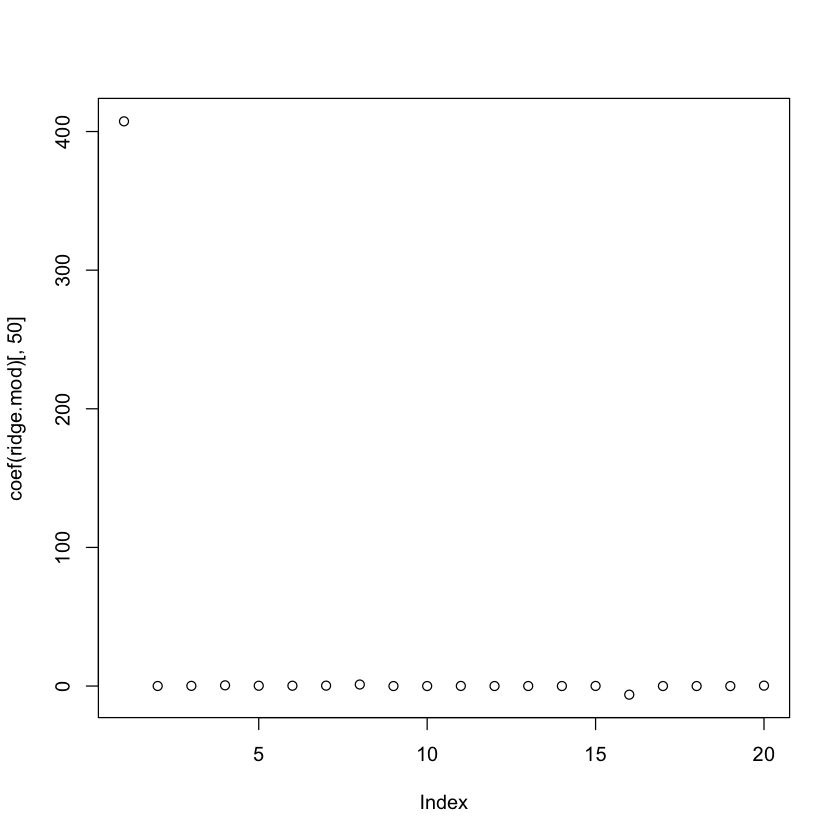

In [17]:
lambda_search_space[50] #getting particular value of lambda
plot(coef(ridge.mod)[,50]) #getting coeff. for that value of lamba, all coeff.

Here you can see that many of them are near zero in value while a few terms retain strong, non-zero values. 
<br>
Now what happens if we make $\lambda$ really _really_ large?

[1] 5722367659

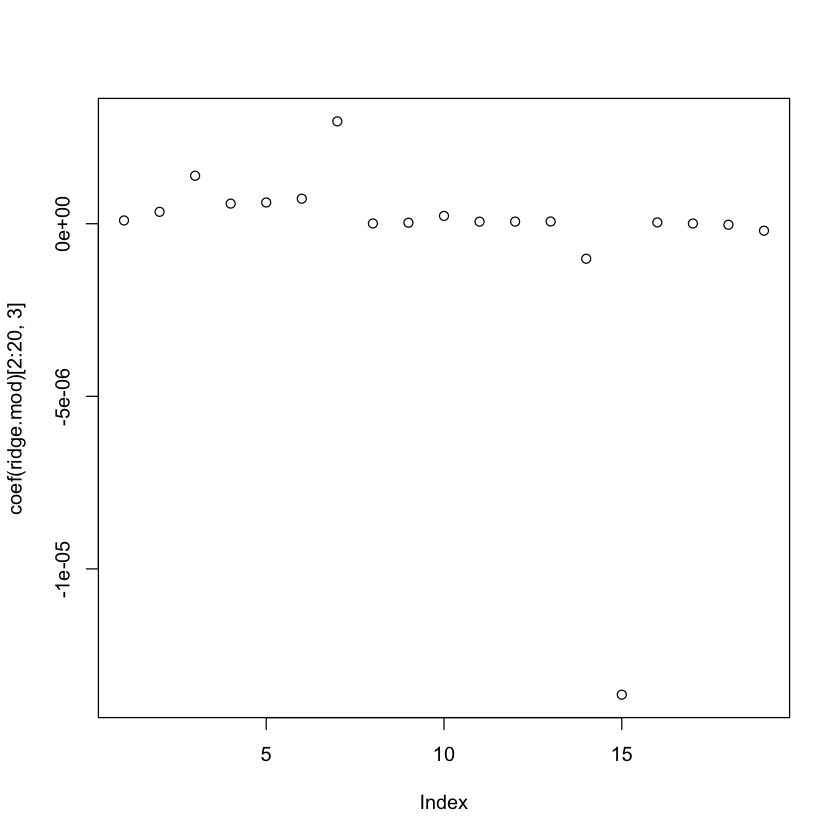

In [18]:
lambda_search_space[3]
plot(coef(ridge.mod)[2:20,3])

Notice a difference between when $\lambda = 11498$ and when $\lambda = 5722367659$? 
<br>
The coefficients are much smaller. The larger the value of $\lambda$, the more sparse the model.
In other words, as $\lambda$ increases, the flexibility of the fit *decreases*. This decreases the variance of the model and increases bias. 

You can test any value of $\lambda$ using the `predict()` function.

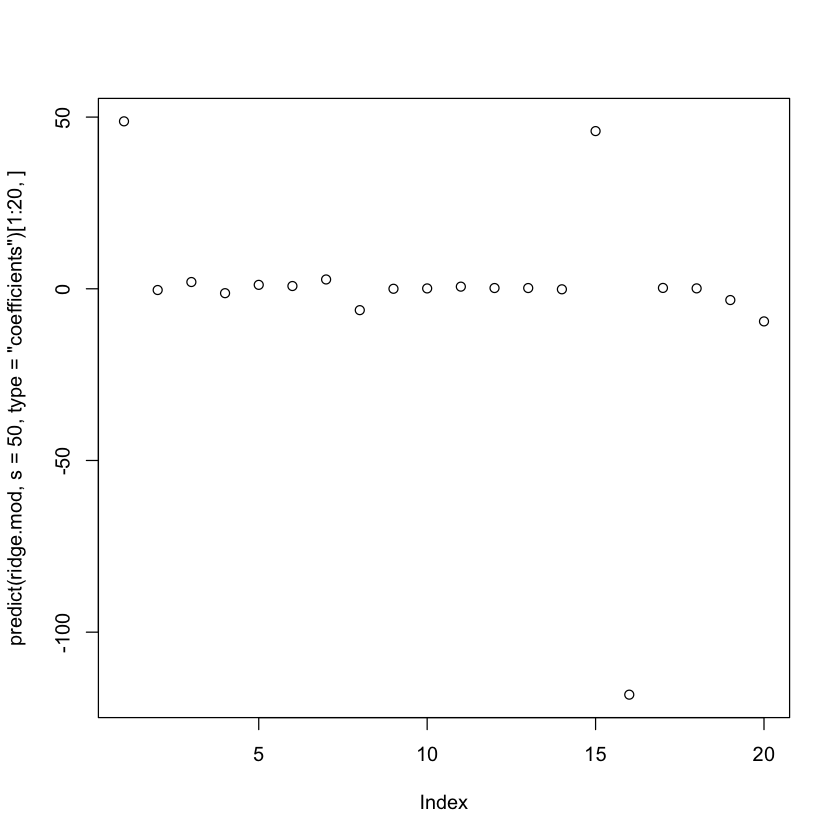

In [19]:
plot(predict(ridge.mod, s=50, type="coefficients")[1:20,]) #s=lambda=50

Let's create a simple 50/50 split for the training and test set for the ridge regression. 

In [20]:
set.seed(1) # Use the same seed so we get the same results

# Create your validation sets
train=sample(1:nrow(x), nrow(x)/2) #50/50 split into training and test sets
test=(-train) #get test indices (not training indices)
y.test = y[test]

# Make a training model using the training set (for all values of lambda)
ridge.mod = glmnet(x[train,], y[train], alpha=0, lambda=lambda_search_space, thresh=1e-12) #threshold specifies the convergence criterion

Let's now test different fits using different $\lambda$.

In [21]:
# With lambda = 1e10 (10^10)
#note that this is like a null, intercept-only model
ridge.pred = predict(ridge.mod, s=1e10, newx=x[test,])
mean((ridge.pred - y.test)^2)

# With lambda = 4 (s=lambda)
ridge.pred = predict(ridge.mod, s=4, newx=x[test,])
mean((ridge.pred - y.test)^2)

# With lambda = 0 (note that this is OLS regression)
ridge.pred = predict(ridge.mod, s=0, newx=x[test,])
mean((ridge.pred - y.test)^2)

[1] 193253.1

[1] 101036.8

[1] 114723.6

When $\lambda$ was large, the MSE was worse than OLS. When it's smaller (but not 0), it improves upon the OLS MSE. Hence we need to maximize the bias-variance tradeoff.

# An important note about validation and test sets

Remember, if we want to test the predictive utility of a model, it's important to separate estimates from training and test data. We did this above at a basic level, for the glm regression variables. But this separation should also include the model and variable selection step (i.e., in this context, $\lambda$). 
So, the determination of which model is best must be made using training and test observations separate from the estimation of the general linear model. If we use the same data to perform best subset selection as we do to estimate and/or test our final model, then the estimate of test error will be contaminated. 
<br>
**Note: You will need sufficient power to split your data into the required number of training and validation sets.** 
<br>
<br>
Here, we need to use a separate training and validation set to find and test the best $\lambda$. Let's find the best $\lambda$ using 10-fold cross-validation.

In [22]:
set.seed(2) # Use the same seed so we get the same results

# Create your validation sets
train=sample(1:nrow(x), nrow(x)/2) #50/50 split into training and test sets
test=(-train) #get test indices (not training indices)

#split each of the training and test phases into two 
#need to have separate validation sets for lambda and for beta estimates

train_hyperparameter = sample(train, length(train)/2)
train_glm = (-train_hyperparameter)

test_hyperparameter = sample(test, length(test)/2)
test_glm = (-test_hyperparameter)

#make sure that the samples do not overlap
sum(test_hyperparameter == train_hyperparameter) 
sum(test_glm == train_glm) 
sum(train_hyperparameter == train_glm) 

[1] 0

[1] 0

[1] 0

[1] 390.7548

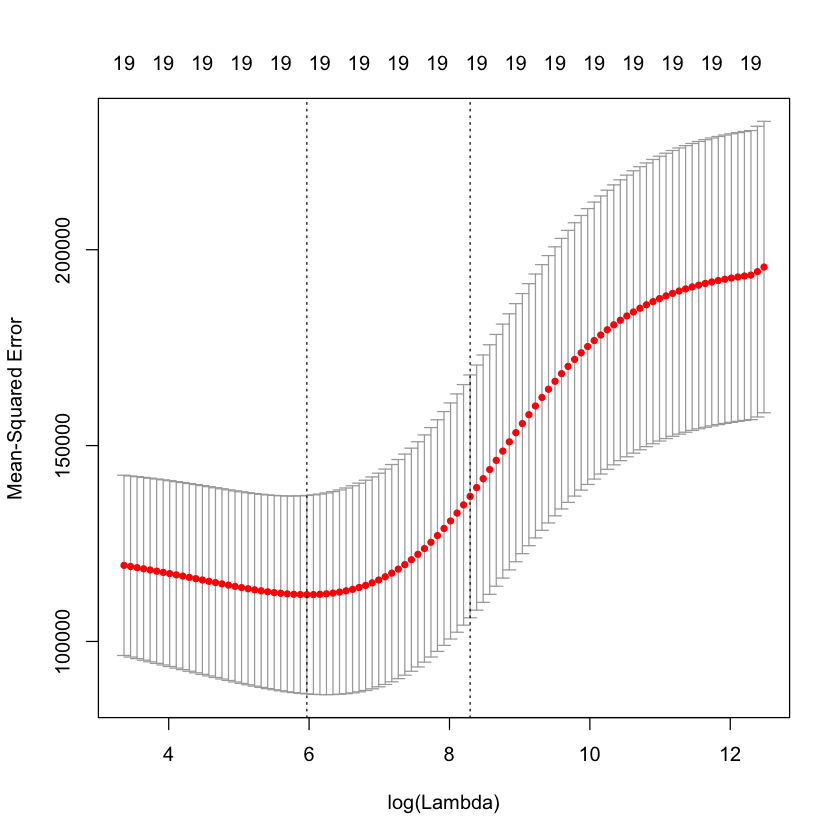

In [23]:
# Using 10-fold CV, cross-validate on the training data
set.seed(1)
cv.out = cv.glmnet(x[train_hyperparameter,], y[train_hyperparameter], alpha=0) #alpha=0=ridge regression
plot(cv.out) #defaults to 10-fold CV
bestlam = cv.out$lambda.min
bestlam

The $\lambda$ with the lowest cross-validation MSE is $\lambda = 390.75$. 
<br>
We can use this value of $\lambda$ to look at our hold-out test accuracy.

In [24]:
#passing in the trained model object, the best lambda, and the test data
ridge.pred = predict(ridge.mod, s=bestlam, newx=x[test_hyperparameter,]) 
mean((ridge.pred -y[test_hyperparameter])^2) #MSE

[1] 117298.1

Using this best lambda, we can also get the actual regression coefficients for all 20 parameters in the model (including the intercept). Here, we refit the ridge regression model on the training dataset dedicated for this purpose (`train_glm`) and then look at coefficient predictions for the `test_glm` dataset. 

In [25]:
# First setup the model
out = glmnet(x[train_glm,],y[train_glm], alpha=0)

# # Then predict.
predict(out, type="coefficients", s=bestlam, newx=x[test_glm,])[1:20,]

(Intercept)         AtBat          Hits         HmRun          Runs 
 28.391473446   0.093455208   0.794484745   2.237452859   0.986234862 
          RBI         Walks         Years        CAtBat         CHits 
  1.106229490   1.153557646   1.738718099   0.009715221   0.050533206 
       CHmRun         CRuns          CRBI        CWalks       LeagueN 
  0.470019858   0.102238031   0.118319739   0.032592523  22.693577691 
    DivisionW       PutOuts       Assists        Errors    NewLeagueN 
-94.591106567   0.122619855  -0.004079666  -0.437693151   9.021129207

---
# LASSO

In order to run LASSO, you repeat the same steps as shown in the example above but replace alpha=0 with alpha=1. 

Alternatively, if you want to do a full elastic net procedure, you  would also fit a range of alpha parameters as well as lambda via separate cross-validation. Importantly, you will need to crossvalidate $\alpha$ and $\lambda$ using separate subsets of data, and then estimate the general linear model regression coefficients using these best hyperparameters on a third, completely separate subset (train and test). The book recombines all subsets to estimate the regression coefficients, but this means that you are reusing some of the data involved in the hyperparameter tuning process, which contaminates the test accuracy for the overall linear model. 

For the sake of time, we will move onto PCR. 


---
# Principal Components Regression (PCR)

The function for executing PCR is part of the [_pls_ package](https://cran.r-project.org/web/packages/pls/pls.pdf). 

In [26]:
# -----------------------------
# 6.7.1 Principal Components Regression (PCR)
# -----------------------------

# Uncomment the next line if you do not have pls package installed
# install.packages("pls")
library(pls)


Attaching package: ‘pls’

The following object is masked from ‘package:stats’:

    loadings



Let's run a PCR on the same data set we have been playing with so far. 

Pay attention to two options in the _pcr()_ function.

* _scale_ = TRUE to standardize the coefficients
* _validation_ = setting to "CV" causes pcr to use a 10-fold cross-validation for each value of `M`, the number of principal components used

In [27]:
set.seed(2)
pcr.fit = pcr(Salary~., data=Hitters, scale=TRUE, validation="CV")
summary(pcr.fit)

Data: 	X dimension: 263 19 
	Y dimension: 263 1
Fit method: svdpc
Number of components considered: 19

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV             452    348.9    352.2    353.5    352.8    350.1    349.1
adjCV          452    348.7    351.8    352.9    352.1    349.3    348.0
       7 comps  8 comps  9 comps  10 comps  11 comps  12 comps  13 comps
CV       349.6    350.9    352.9     353.8     355.0     356.2     363.5
adjCV    348.5    349.8    351.6     352.3     353.4     354.5     361.6
       14 comps  15 comps  16 comps  17 comps  18 comps  19 comps
CV        355.2     357.4     347.6     350.1     349.2     352.6
adjCV     352.8     355.2     345.5     347.6     346.7     349.8

TRAINING: % variance explained
        1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps  8 comps
X         38.31    60.16    70.84    79.03    84.29    88.63    92.26    94.96
Salary    4

The output shows the validation and training set performance as a function of the number of components included in the model. At the top is shown an adjusted root mean squared error (RMSEP, root mean squared error of prediction) for the validation set, with as many components as you have access to (19 here).

Below, for the training set, you can see the % variance explained in the predictors and the response as function of the number of components in the model (see Chapter 10 for more information on this). This can be thought of as the amount of information captured using M components. 

It would be easier to interpret this data visually. We can visualize the results using the `validationplot()` function included in the `pls` package.

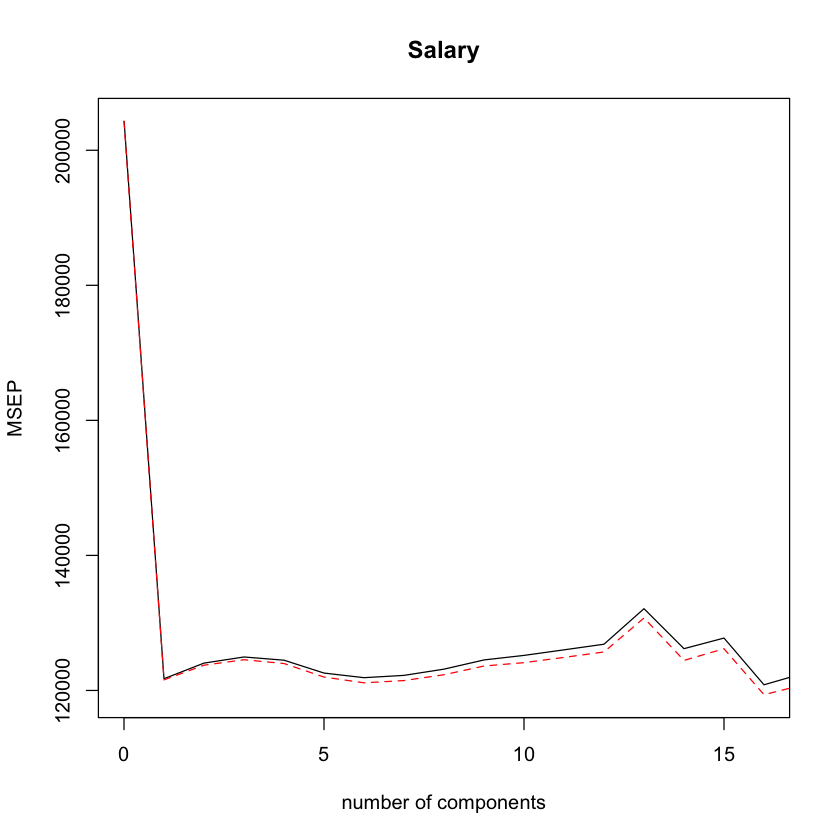

In [28]:
validationplot(pcr.fit, val.type="MSEP", xlim=c(0,16)) #MSEP is mean-squared error of prediction

Notice that the lowest MSE is the model with M=16 components, which barely improves on the single component model.

But previously we were using all of the data. Let's conduct a validation test in order to find the right number of components to use in the model and then evaluate the hold-out _test set_ error.

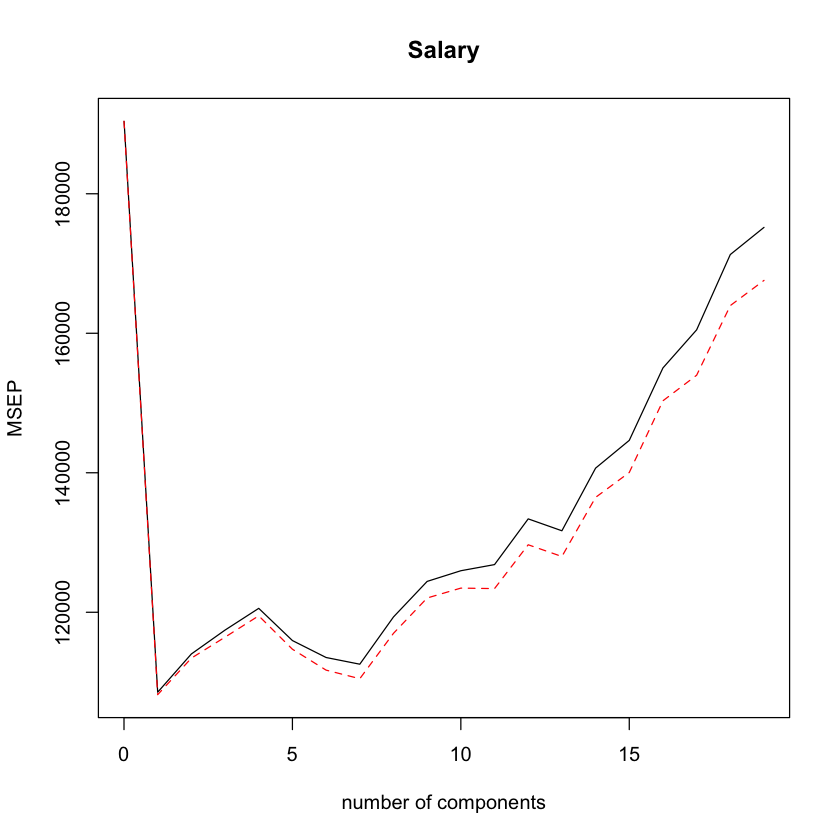

In [29]:
set.seed(1)
pcr.fit = pcr(Salary~., data=Hitters, scale=TRUE, subset=train_hyperparameter, validation="CV")
validationplot(pcr.fit, val.type="MSEP")

The _summary()_ function is going to be useful here for finding the best value.

In [30]:
summary(pcr.fit)

Data: 	X dimension: 65 19 
	Y dimension: 65 1
Fit method: svdpc
Number of components considered: 19

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV           436.3    329.5    337.7    342.7    347.2    340.5    336.9
adjCV        436.3    328.9    336.8    341.2    345.7    338.7    334.2
       7 comps  8 comps  9 comps  10 comps  11 comps  12 comps  13 comps
CV       335.5    345.4    352.7     354.9     356.1     365.2     362.9
adjCV    332.4    342.0    349.4     351.4     351.3     360.1     357.8
       14 comps  15 comps  16 comps  17 comps  18 comps  19 comps
CV        375.1     380.3     393.7     400.6     413.9     418.5
adjCV     369.4     374.2     387.7     392.4     404.9     409.4

TRAINING: % variance explained
        1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps  8 comps
X         39.83    60.45    71.23    79.80    85.58    90.06    93.14    95.35
Salary    44.

We see that the best fit, using the adjusted-CV criterion, is the model that uses 1 principal component. 

So let's take that model and evaluate the _test fit_.

In [31]:
pcr.pred = predict(pcr.fit, x[test_hyperparameter,], ncomp=1)
mean((pcr.pred-y[test_hyperparameter])^2)

[1] 126235.9

Now that we've selected the number of components, let's train and test the overall glm.

In [32]:
pcr.fit = pcr(y[train_glm]~x[train_glm,], scale=TRUE, ncomp=1)
summary(pcr.fit)

pcr.pred = predict(pcr.fit, x[test_glm,], ncomp=1)
mean((pcr.pred-y[test_glm])^2)

Data: 	X dimension: 198 19 
	Y dimension: 198 1
Fit method: svdpc
Number of components considered: 1
TRAINING: % variance explained
              1 comps
X               38.46
y[train_glm]    39.91


[1] 99431.09

---
# Partial Least Squares (PLS)

The _plsr()_ function is executed the exact same way as _pcr()_. Change the function calls above from _pcr_ to _plsr_ to see the differences in results.

# Problem set

In this exercise, we will predict the number of applications received
using the other variables in the College data set.


In [33]:
library(ISLR)
head(College)

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15
Albertson College,Yes,587,479,158,38,62,678,41,13500,3335,500,675,67,73,9.4,11,9727,55


(a) Split the data set into a training set and a test set.

(b) Fit a linear model using least squares on the training set, and
report the test error obtained.

(c) Fit a ridge regression model on the training set, with λ chosen
by cross-validation. Report the test error obtained.

(d) Fit a lasso model on the training set, with λ chosen by crossvalidation.
Report the test error obtained, along with the number
of non-zero coefficient estimates.

(e) Fit a PCR model on the training set, with M chosen by crossvalidation.
Report the test error obtained, along with the value
of M selected by cross-validation.

(f) Fit a PLS model on the training set, with M chosen by crossvalidation.
Report the test error obtained, along with the value
of M selected by cross-validation.

(g) Comment on the results obtained. How accurately can we predict
the number of college applications received? Is there much
difference among the test errors resulting from these five approaches?